### aim: translate hilda optimisation to python 

based on

    /gpfs/home/e415/analysis/pulse/medusa/optimisation/optimisation.F90

### date: 

In [306]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [307]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [308]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [309]:
oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP1.csv'
atmoco2_SSP1 = './data/csvs/atmco2-SSP1.csv'

## hilda optimalization code, put in runner.py for 

In [310]:
run = False
if run:
    #put python script here
    ### hilda optimizer

    import numpy as np
    import pandas as pd

    jit = 150
    jdat = 150
    obf = np.zeros(jit + 1)  # Adding 1 since Fortran arrays are 1-indexed
    abf = np.zeros(jit + 1)
    ocfit = np.zeros(jit + 1)

    atmoco2_SSP1 = './data/csvs/atmco2-SSP1.csv'
    file_path = atmoco2_SSP1
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Display the first few rows of the DataFrame to verify it's loaded correctly
    time = df.year.to_numpy()
    atm = df.atmco2.to_numpy()
    pulse0 = np.zeros_like(atm)

    # print(atm[0])
    for i in range(1,len(pulse0)):
        pulse0[i] = (atm[i] - atm[i-1]) * 2.123 #gcb, table1


    oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP1_SO.csv'
    file_path = oceansink
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)
    rocdat = df.Cflx.to_numpy()

    def get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3):

        for it in range(1, jit + 1):  # Adjusting for Python's 0-indexing
            rit = float(it)
            abf[it] = ra0 + ra1 * np.exp(-rit / rt1) + ra2 * np.exp(-rit / rt2) + ra3 * np.exp(-rit / rt3)

            if it > 1:
                obf[it] = abf[it - 1] - abf[it]
            else:
                obf[it] = 1. - abf[it]

            ocfit[it] = 0
            for jt in range(1, it + 1):
                ocfit[it] += pulse0[jt - 1] * obf[it - jt + 1] 

        # Calculate RMSE
        rsum = np.sum((rocdat[:jdat] - ocfit[:jdat]) ** 2)
        #print(rsum)

        return ocfit, rsum


    ra0 = 0.7; ra0mi = 0.35; ra0ra = 0.7
    ra1 = 0; ra1mi = 0; ra1ra = 2
    ra2 = 0.1; ra2mi = 0; ra2ra = (ra2-ra2mi) *2
    ra3 = 0.2; ra3mi = 0; ra3ra = (ra3-ra3mi) *2
    rt1 = 1; rt1mi = 0.1; rt1rt = (rt1-rt1mi) *2
    rt2 = 38; rt2mi = 20; rt2rt = (rt2-rt2mi) *2
    rt3 = 200; rt3mi = 100; rt3rt = (rt3-rt3mi) *2

    jpmax = 8

    ra0_i = np.zeros(jpmax**7)
    ra1_i = np.zeros(jpmax**7)
    ra2_i = np.zeros(jpmax**7)
    ra3_i = np.zeros(jpmax**7)
    rt1_i = np.zeros(jpmax**7)
    rt2_i = np.zeros(jpmax**7)
    rt3_i = np.zeros(jpmax**7)
    rsum_i = np.zeros(jpmax**7)

    ind = 0
    for ra0i in range(0,jpmax):
        ra0 = ra0mi + (ra0ra/(jpmax-1))*ra0i

        for ra1i in range(0,jpmax):
            ra1 = ra1mi + (ra1ra/(jpmax-1))*ra1i

            for ra2i in range(0,jpmax):
                ra2 = ra2mi + (ra2ra/(jpmax-1))*ra2i

                for ra3i in range(0,jpmax):
                    ra3 = ra3mi + (ra3ra/(jpmax-1))*ra3i

                    for rt1i in range(0,jpmax):
                        rt1 = rt1mi + (rt1rt/(jpmax-1))*rt1i

                        for rt2i in range(0,jpmax):
                            rt2 = rt2mi + (rt2rt/(jpmax-1))*rt2i

                            for rt3i in range(0,jpmax):
                                rt3 = rt3mi + (rt3rt/(jpmax-1))*rt3i


                                ra0_i[ind] = ra0
                                ra1_i[ind] = ra1 
                                ra2_i[ind] = ra2 
                                ra3_i[ind] = ra3 
                                rt1_i[ind] = rt1 
                                rt2_i[ind] = rt2 
                                rt3_i[ind] = rt3 
                                ocfit, rsum = get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3)
                                rsum_i[ind] = rsum
                                ind = ind+1
                                if ind%1000 == 0:
                                    print(ind)


    df = pd.DataFrame([ra0_i,ra1_i,ra2_i,ra3_i,rt1_i,rt2_i,rt3_i,rsum_i]).T
    df.columns = ['ra0','ra1','ra2','ra3','rt1','rt2','rt3','rsum']
    df.wheremade = '/scratch/BOE-SOcarbon/hilda-optimisation.ipynb'
    df.to_csv('./data/hildaoptimization_firstpass.csv')


In [311]:
run = False
if run:
    #put python script here
    ### hilda optimizer

    import numpy as np
    import pandas as pd

    jit = 150
    jdat = 150
    obf = np.zeros(jit + 1)  # Adding 1 since Fortran arrays are 1-indexed
    abf = np.zeros(jit + 1)
    ocfit = np.zeros(jit + 1)

    atmoco2_SSP1 = './data/csvs/atmco2-SSP1.csv'
    file_path = atmoco2_SSP1
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Display the first few rows of the DataFrame to verify it's loaded correctly
    time = df.year.to_numpy()
    atm = df.atmco2.to_numpy()
    pulse0 = np.zeros_like(atm)

    # print(atm[0])
    for i in range(1,len(pulse0)):
        pulse0[i] = (atm[i] - atm[i-1]) * 2.123 #gcb, table1


    oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP1_SO.csv'
    file_path = oceansink
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)
    rocdat = df.Cflx.to_numpy()

    def get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3):

        for it in range(1, jit + 1):  # Adjusting for Python's 0-indexing
            rit = float(it)
            abf[it] = ra0 + ra1 * np.exp(-rit / rt1) + ra2 * np.exp(-rit / rt2) + ra3 * np.exp(-rit / rt3)

            if it > 1:
                obf[it] = abf[it - 1] - abf[it]
            else:
                obf[it] = 1. - abf[it]

            ocfit[it] = 0
            for jt in range(1, it + 1):
                ocfit[it] += pulse0[jt - 1] * obf[it - jt + 1] 

        # Calculate RMSE
        rsum = np.sum((rocdat[:jdat] - ocfit[:jdat]) ** 2)
        #print(rsum)

        return ocfit, rsum


    ra0 = 0.7; ra0mi = 0.35; ra0ra = 0.7
    ra1 = 0; ra1mi = 0; ra1ra = 2
    ra2 = 0.1; ra2mi = 0; ra2ra = (ra2-ra2mi) *2
    ra3 = 0.2; ra3mi = 0; ra3ra = (ra3-ra3mi) *2
    rt1 = 1; rt1mi = 0.1; rt1rt = (rt1-rt1mi) *2
    rt2 = 38; rt2mi = 20; rt2rt = (rt2-rt2mi) *2
    rt3 = 200; rt3mi = 100; rt3rt = (rt3-rt3mi) *2

    jpmax = 7

    ra0_i = np.zeros(jpmax**7)
    ra1_i = np.zeros(jpmax**7)
    ra2_i = np.zeros(jpmax**7)
    ra3_i = np.zeros(jpmax**7)
    rt1_i = np.zeros(jpmax**7)
    rt2_i = np.zeros(jpmax**7)
    rt3_i = np.zeros(jpmax**7)
    rsum_i = np.zeros(jpmax**7)

    ind = 0
    for ra0i in range(0,jpmax):
        ra0mi = 0.4; ra0ra = 0.8 - 0.4
        ra0 = ra0mi + (ra0ra/(jpmax-1))*ra0i

        for ra1i in range(0,jpmax):
            ra1mi = 0; ra1ra = 2
            ra1 = ra1mi + (ra1ra/(jpmax-1))*ra1i

            for ra2i in range(0,jpmax):
                ra2mi = 0; ra2ra = 0.14
                ra2 = ra2mi + (ra2ra/(jpmax-1))*ra2i

                for ra3i in range(0,jpmax):
                    ra3mi = 0.2; ra3ra = 0.3
                    ra3 = ra3mi + (ra3ra/(jpmax-1))*ra3i

                    for rt1i in range(0,jpmax):
                        rt1mi = 0.01; rt1ra = 0.49
                        rt1 = rt1mi + (rt1rt/(jpmax-1))*rt1i

                        for rt2i in range(0,jpmax):
                            rt2mi = 0.01; rt2ra = 0.49
                            rt2 = rt2mi + (rt2rt/(jpmax-1))*rt2i

                            for rt3i in range(0,jpmax):
                                rt3mi = 100; rt3ra = 300
                                rt3 = rt3mi + (rt3rt/(jpmax-1))*rt3i


                                ra0_i[ind] = ra0
                                ra1_i[ind] = ra1 
                                ra2_i[ind] = ra2 
                                ra3_i[ind] = ra3 
                                rt1_i[ind] = rt1 
                                rt2_i[ind] = rt2 
                                rt3_i[ind] = rt3 
                                ocfit, rsum = get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3)
                                rsum_i[ind] = rsum
                                ind = ind+1
                                if ind%1000 == 0:
                                    print(ind)


    df = pd.DataFrame([ra0_i,ra1_i,ra2_i,ra3_i,rt1_i,rt2_i,rt3_i,rsum_i]).T
    df.columns = ['ra0','ra1','ra2','ra3','rt1','rt2','rt3','rsum']
    df.wheremade = '/scratch/BOE-SOcarbon/hilda-optimisation.ipynb'
    df.to_csv('./data/hildaoptimization_secondpass.csv')


### third pass, put in runner.py

In [312]:
run = False
if run:
    #put python script here
    ### hilda optimizer

    import numpy as np
    import pandas as pd

    jit = 150
    jdat = 150
    obf = np.zeros(jit + 1)  # Adding 1 since Fortran arrays are 1-indexed
    abf = np.zeros(jit + 1)
    ocfit = np.zeros(jit + 1)

    atmoco2_SSP1 = './data/csvs/atmco2-SSP1.csv'
    file_path = atmoco2_SSP1
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Display the first few rows of the DataFrame to verify it's loaded correctly
    time = df.year.to_numpy()
    atm = df.atmco2.to_numpy()
    pulse0 = np.zeros_like(atm)

    # print(atm[0])
    for i in range(1,len(pulse0)):
        pulse0[i] = (atm[i] - atm[i-1]) * 2.123 #gcb, table1


    oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP1_SO.csv'
    file_path = oceansink
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)
    rocdat = df.Cflx.to_numpy()

    def get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3):

        for it in range(1, jit + 1):  # Adjusting for Python's 0-indexing
            rit = float(it)
            abf[it] = ra0 + ra1 * np.exp(-rit / rt1) + ra2 * np.exp(-rit / rt2) + ra3 * np.exp(-rit / rt3)

            if it > 1:
                obf[it] = abf[it - 1] - abf[it]
            else:
                obf[it] = 1. - abf[it]

            ocfit[it] = 0
            for jt in range(1, it + 1):
                ocfit[it] += pulse0[jt - 1] * obf[it - jt + 1] 

        # Calculate RMSE
        rsum = np.sum((rocdat[:jdat] - ocfit[:jdat]) ** 2)
        #print(rsum)

        return ocfit, rsum


    ra0 = 0.7; ra0mi = 0.35; ra0ra = 0.7
    ra1 = 0; ra1mi = 0; ra1ra = 2
    ra2 = 0.1; ra2mi = 0; ra2ra = (ra2-ra2mi) *2
    ra3 = 0.2; ra3mi = 0; ra3ra = (ra3-ra3mi) *2
    rt1 = 1; rt1mi = 0.1; rt1rt = (rt1-rt1mi) *2
    rt2 = 38; rt2mi = 20; rt2rt = (rt2-rt2mi) *2
    rt3 = 200; rt3mi = 100; rt3rt = (rt3-rt3mi) *2

    jpmax = 8

    ra0_i = np.zeros(jpmax**7)
    ra1_i = np.zeros(jpmax**7)
    ra2_i = np.zeros(jpmax**7)
    ra3_i = np.zeros(jpmax**7)
    rt1_i = np.zeros(jpmax**7)
    rt2_i = np.zeros(jpmax**7)
    rt3_i = np.zeros(jpmax**7)
    rsum_i = np.zeros(jpmax**7)

    ind = 0
    for ra0i in range(0,jpmax):
        ra0mi = 0.4; ra0ra = 0.8 - 0.4
        ra0 = ra0mi + (ra0ra/(jpmax-1))*ra0i

        for ra1i in range(0,jpmax):
            ra1mi = 0; ra1ra = 2
            ra1 = ra1mi + (ra1ra/(jpmax-1))*ra1i

            for ra2i in range(0,jpmax):
                ra2mi = 0; ra2ra = 0.14
                ra2 = ra2mi + (ra2ra/(jpmax-1))*ra2i

                for ra3i in range(0,jpmax):
                    ra3mi = 0.2; ra3ra = 0.3
                    ra3 = ra3mi + (ra3ra/(jpmax-1))*ra3i

                    for rt1i in range(0,jpmax):
                        rt1mi = 0.01; rt1ra = 0.49
                        rt1 = rt1mi + (rt1rt/(jpmax-1))*rt1i

                        for rt2i in range(0,jpmax):
                            rt2mi = 0.01; rt2ra = 0.49
                            rt2 = rt2mi + (rt2rt/(jpmax-1))*rt2i

                            for rt3i in range(0,jpmax):
                                rt3mi = 100; rt3ra = 300
                                rt3 = rt3mi + (rt3rt/(jpmax-1))*rt3i


                                ra0_i[ind] = ra0
                                ra1_i[ind] = ra1 
                                ra2_i[ind] = ra2 
                                ra3_i[ind] = ra3 
                                rt1_i[ind] = rt1 
                                rt2_i[ind] = rt2 
                                rt3_i[ind] = rt3 
                                ocfit, rsum = get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3)
                                rsum_i[ind] = rsum
                                ind = ind+1
                                if ind%1000 == 0:
                                    print(ind)


    df = pd.DataFrame([ra0_i,ra1_i,ra2_i,ra3_i,rt1_i,rt2_i,rt3_i,rsum_i]).T
    df.columns = ['ra0','ra1','ra2','ra3','rt1','rt2','rt3','rsum']
    df.wheremade = '/scratch/BOE-SOcarbon/hilda-optimisation.ipynb'
    df.to_csv('./data/hildaoptimization_thirdpass.csv')

Text(0.5, 1.0, 'pulse response model \n pulse$_t$ = (atmco2$_t$ - atmco2$_{t-1}$) * 2.213')

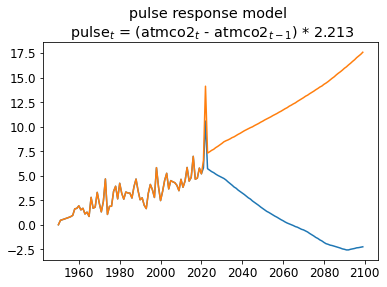

In [313]:
atmoco2_SSP1 = './data/csvs/atmco2-SSP1.csv'
file_path = atmoco2_SSP1
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify it's loaded correctly
time = df.year.to_numpy()
atm = df.atmco2.to_numpy()
pulse0 = np.zeros_like(atm)

# print(atm[0])
for i in range(1,len(pulse0)):
    pulse0[i] = (atm[i] - atm[i-1]) * 2.123 #gcb, table1


atmoco2_SSP3 = './data/csvs/atmco2-SSP3.csv'
file_path = atmoco2_SSP3
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify it's loaded correctly
time = df.year.to_numpy()
atm = df.atmco2.to_numpy()
pulse1 = np.zeros_like(atm)

# print(atm[0])
for i in range(1,len(pulse0)):
    pulse1[i] = (atm[i] - atm[i-1]) * 2.123 #gcb, table1

    
plt.figure()
plt.plot(time,pulse0, label = 'pulse response, ssp1')
plt.plot(time,pulse1, label = 'pulse response, ssp3')
plt.title('pulse response model \n pulse$_t$ = (atmco2$_t$ - atmco2$_{t-1}$) * 2.213')

index 0: r20.4941949344708639, 2100 ssp3-ssp1 PR:2.1314253033664015, ssp3_PR-ssp3_MED: 0.924297328974583
index 1: r20.4942066102288999, 2100 ssp3-ssp1 PR:2.131422990026652, ssp3_PR-ssp3_MED: 0.9242942445449207
index 2: r20.4942183756426923, 2100 ssp3-ssp1 PR:2.1314206766869015, ssp3_PR-ssp3_MED: 0.9242911601152575
index 3: r20.4942302307122408, 2100 ssp3-ssp1 PR:2.1314183633471515, ssp3_PR-ssp3_MED: 0.9242880756855947
index 4: r20.4942421754375458, 2100 ssp3-ssp1 PR:2.1314160500074015, ssp3_PR-ssp3_MED: 0.9242849912559319
index 5: r20.4942542098186067, 2100 ssp3-ssp1 PR:2.1314137366676515, ssp3_PR-ssp3_MED: 0.9242819068262691
index 6: r20.5019640066876627, 2100 ssp3-ssp1 PR:2.219483797444808, ssp3_PR-ssp3_MED: 0.9561087191435755
index 7: r20.5019770085424331, 2100 ssp3-ssp1 PR:2.219481484105058, ssp3_PR-ssp3_MED: 0.9561056347139127
index 8: r20.5019901000529599, 2100 ssp3-ssp1 PR:2.2194791707653074, ssp3_PR-ssp3_MED: 0.9561025502842495
index 9: r20.5020032812192425, 2100 ssp3-ssp1 PR:2

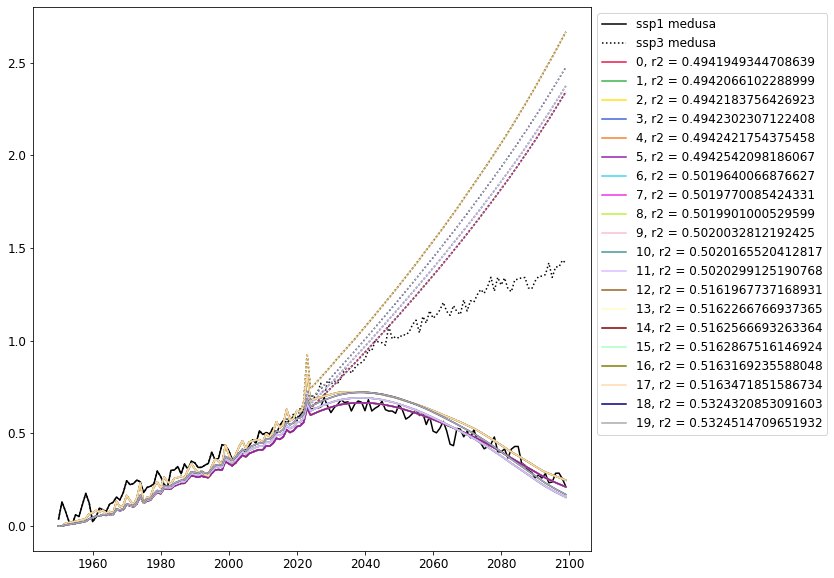

In [314]:
jit = jdat = 150
oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP1_SO.csv'
file_path = oceansink
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
rocdat = df.Cflx.to_numpy()

oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP3_SO.csv'
file_path = oceansink
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
rocdat1 = df.Cflx.to_numpy()



cols = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', \
        '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', \
        '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000',\
        '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000'
]

df = pd.read_csv('./data/hildaoptimization_firstpass.csv')
df_sorted = df.sort_values(by='rsum', ascending=True)
df_loc = df_sorted.head(50)


def get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3):

    obf = np.zeros(jit + 1)  # Adding 1 since Fortran arrays are 1-indexed
    abf = np.zeros(jit + 1)
    ocfit = np.zeros(jit + 1)
    ocfit1 = np.zeros(jit + 1)
    
    for it in range(1, jit + 1):  # Adjusting for Python's 0-indexing
        rit = float(it)
        abf[it] = ra0 + ra1 * np.exp(-rit / rt1) + ra2 * np.exp(-rit / rt2) + ra3 * np.exp(-rit / rt3)

        if it > 1:
            obf[it] = abf[it - 1] - abf[it]
        else:
            obf[it] = 1. - abf[it]

        ocfit[it] = 0
        ocfit1[it] = 0
        for jt in range(1, it + 1):
            ocfit[it] += pulse0[jt - 1] * obf[it - jt + 1] 
            ocfit1[it] += pulse1[jt - 1] * obf[it - jt + 1] 

    # Calculate RMSE
    rsum = np.sum((rocdat[:jdat] - ocfit[:jdat]) ** 2)
    #print(rsum)

    return ocfit, ocfit1, rsum

ra0 = df_loc['ra0'].to_numpy()
ra1 = df_loc['ra1'].to_numpy()
ra2 = df_loc['ra2'].to_numpy()
ra3 = df_loc['ra3'].to_numpy()
rt1 = df_loc['rt1'].to_numpy()
rt2 = df_loc['rt2'].to_numpy()
rt3 = df_loc['rt3'].to_numpy()


plt.figure(figsize = (10,10))
plt.plot(time,rocdat[0:150], color = 'k', label = 'ssp1 medusa')
plt.plot(time,rocdat1[0:150], color = 'k', linestyle = ':', label = 'ssp3 medusa')
for ind in range(0,20):
    ocfit0, ocfit1, rsum = get_ocfit(rocdat,ra0[ind],ra1[ind],ra2[ind],ra3[ind],rt1[ind],rt2[ind],rt3[ind])
    
    udif = ocfit1[149] - ocfit0[149]  
    udifroc = ocfit1[149] - rocdat1[149] 
    print(f'index {ind}: r2{rsum}, 2100 ssp3-ssp1 PR:{udif}, ssp3_PR-ssp3_MED: {udifroc}')
    
    plt.plot(time,ocfit0[0:150], label = f'{ind}, r2 = {rsum}', color = cols[ind])
    plt.plot(time,ocfit1[0:150], linestyle = ':', color = cols[ind])
    



plt.legend(bbox_to_anchor = [1,1])

index 0: r2 0.34403943525003106, 2100 ssp3-ssp1 PR:2.2326655921871192, ssp3_PR-ssp3_MED: 1.026238955828161
index 1: r2 0.34403943525003106, 2100 ssp3-ssp1 PR:2.2326655921871192, ssp3_PR-ssp3_MED: 1.026238955828161
index 2: r2 0.34403943525003106, 2100 ssp3-ssp1 PR:2.2326655921871192, ssp3_PR-ssp3_MED: 1.026238955828161
index 3: r2 0.34403943525003106, 2100 ssp3-ssp1 PR:2.2326655921871192, ssp3_PR-ssp3_MED: 1.026238955828161
index 4: r2 0.34403943525003106, 2100 ssp3-ssp1 PR:2.2326655921871192, ssp3_PR-ssp3_MED: 1.026238955828161
index 5: r2 0.34403943525003106, 2100 ssp3-ssp1 PR:2.2326655921871192, ssp3_PR-ssp3_MED: 1.026238955828161
index 6: r2 0.34403943525003106, 2100 ssp3-ssp1 PR:2.2326655921871192, ssp3_PR-ssp3_MED: 1.026238955828161
index 7: r2 0.34403943525003106, 2100 ssp3-ssp1 PR:2.2326655921871192, ssp3_PR-ssp3_MED: 1.026238955828161
index 8: r2 0.34403943525003106, 2100 ssp3-ssp1 PR:2.2326655921871192, ssp3_PR-ssp3_MED: 1.026238955828161
index 9: r2 0.34403943525003106, 2100

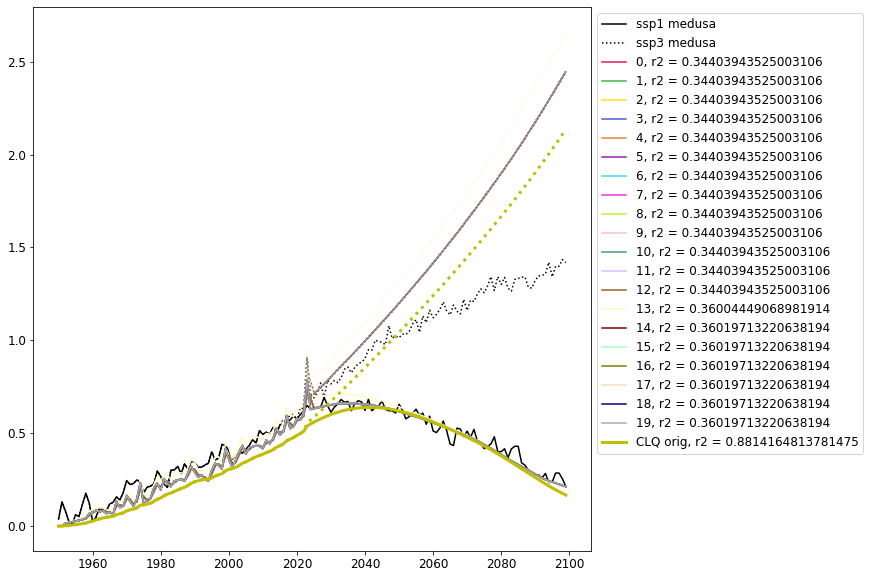

In [315]:
oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP1_SO.csv'
file_path = oceansink
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
rocdat = df.Cflx.to_numpy()

oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP3_SO.csv'
file_path = oceansink
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
rocdat1 = df.Cflx.to_numpy()



cols = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', \
        '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', \
        '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000',\
        '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000'
]

df = pd.read_csv('./data/hildaoptimization_secondpass.csv')
df_sorted = df.sort_values(by='rsum', ascending=True)
df_loc = df_sorted.head(50)


def get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3):

    obf = np.zeros(jit + 1)  # Adding 1 since Fortran arrays are 1-indexed
    abf = np.zeros(jit + 1)
    ocfit = np.zeros(jit + 1)
    ocfit1 = np.zeros(jit + 1)
    
    for it in range(1, jit + 1):  # Adjusting for Python's 0-indexing
        rit = float(it)
        abf[it] = ra0 + ra1 * np.exp(-rit / rt1) + ra2 * np.exp(-rit / rt2) + ra3 * np.exp(-rit / rt3)

        if it > 1:
            obf[it] = abf[it - 1] - abf[it]
        else:
            obf[it] = 1. - abf[it]

        ocfit[it] = 0
        ocfit1[it] = 0
        for jt in range(1, it + 1):
            ocfit[it] += pulse0[jt - 1] * obf[it - jt + 1] 
            ocfit1[it] += pulse1[jt - 1] * obf[it - jt + 1] 

    # Calculate RMSE
    rsum = np.sum((rocdat[:jdat] - ocfit[:jdat]) ** 2)
    #print(rsum)

    return ocfit, ocfit1, rsum

ra0 = df_loc['ra0'].to_numpy()
ra1 = df_loc['ra1'].to_numpy()
ra2 = df_loc['ra2'].to_numpy()
ra3 = df_loc['ra3'].to_numpy()
rt1 = df_loc['rt1'].to_numpy()
rt2 = df_loc['rt2'].to_numpy()
rt3 = df_loc['rt3'].to_numpy()


plt.figure(figsize = (10,10))
plt.plot(time,rocdat[0:150], color = 'k', label = 'ssp1 medusa')
plt.plot(time,rocdat1[0:150], color = 'k', linestyle = ':', label = 'ssp3 medusa')
for ind in range(0,20):
    ocfit0, ocfit1, rsum = get_ocfit(rocdat,ra0[ind],ra1[ind],ra2[ind],ra3[ind],rt1[ind],rt2[ind],rt3[ind])
    
    udif = ocfit1[149] - ocfit0[149]  
    udifroc = ocfit1[149] - rocdat1[149] 
    print(f'index {ind}: r2 {rsum}, 2100 ssp3-ssp1 PR:{udif}, ssp3_PR-ssp3_MED: {udifroc}')
    
    plt.plot(time,ocfit0[0:150], label = f'{ind}, r2 = {rsum}', color = cols[ind])
    plt.plot(time,ocfit1[0:150], linestyle = ':', color = cols[ind])

ra0 = 0.7; ra0mi = 0.35; ra0ra = 0.7
ra1 = 0; ra1mi = 0; ra1ra = 2
ra2 = 0.1; ra2mi = 0; ra2ra = (ra2-ra2mi) *2
ra3 = 0.2; ra3mi = 0; ra3ra = (ra3-ra3mi) *2
rt1 = 1; rt1mi = 0.1; rt1rt = (rt1-rt1mi) *2
rt2 = 38; rt2mi = 20; rt2rt = (rt2-rt2mi) *2
rt3 = 200; rt3mi = 100; rt3rt = (rt3-rt3mi) *2    

ocfit0, ocfit1, rsum = get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3)
udif = ocfit1[149] - ocfit0[149]  
udifroc = ocfit1[149] - rocdat1[149] 
print(f'CLQ orig: r2 {rsum}, 2100 ssp3-ssp1 PR:{udif}, ssp3_PR-ssp3_MED: {udifroc}')

plt.plot(time,ocfit0[0:150], label = f'CLQ orig, r2 = {rsum}', color = 'y', linewidth = 3)
plt.plot(time,ocfit1[0:150], linestyle = ':', color = 'y', linewidth = 3)
    
    
plt.legend(bbox_to_anchor = [1,1])

index 0: r2 0.04503342138851826, 2100 ssp3-ssp1 PR:2.336463682238865, ssp3_PR-ssp3_MED: 1.1235956115660326
index 1: r2 0.045329223520972343, 2100 ssp3-ssp1 PR:2.3373497095599483, ssp3_PR-ssp3_MED: 1.124772501639762
index 2: r2 0.045329223520972343, 2100 ssp3-ssp1 PR:2.3373497095599483, ssp3_PR-ssp3_MED: 1.124772501639762
index 3: r2 0.045329223520972343, 2100 ssp3-ssp1 PR:2.3373497095599483, ssp3_PR-ssp3_MED: 1.124772501639762
index 4: r2 0.045329223520972343, 2100 ssp3-ssp1 PR:2.3373497095599483, ssp3_PR-ssp3_MED: 1.124772501639762
index 5: r2 0.045329223520972343, 2100 ssp3-ssp1 PR:2.3373497095599483, ssp3_PR-ssp3_MED: 1.124772501639762
index 6: r2 0.045329223520972343, 2100 ssp3-ssp1 PR:2.3373497095599483, ssp3_PR-ssp3_MED: 1.124772501639762
index 7: r2 0.045329223520972343, 2100 ssp3-ssp1 PR:2.3373497095599483, ssp3_PR-ssp3_MED: 1.124772501639762
index 8: r2 0.045329223520972343, 2100 ssp3-ssp1 PR:2.3373497095599483, ssp3_PR-ssp3_MED: 1.124772501639762
index 9: r2 0.045329223520972

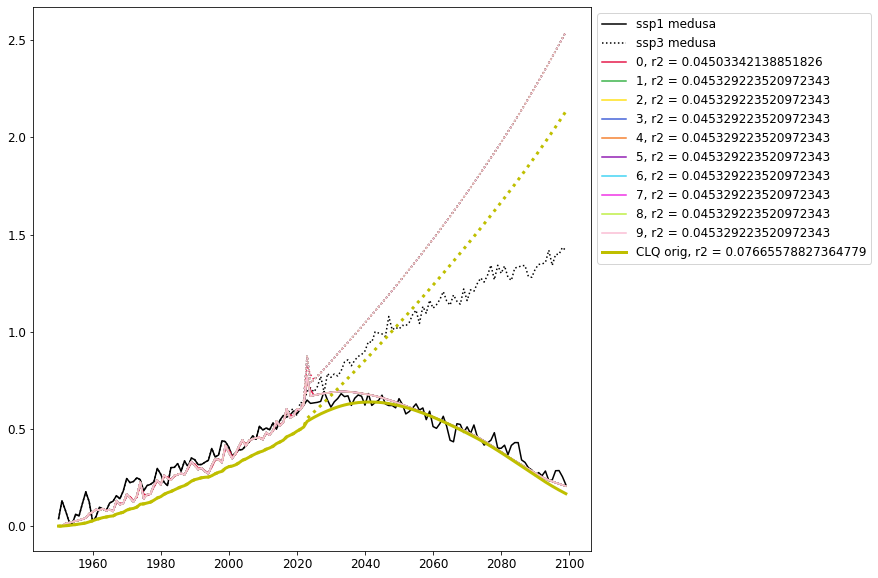

In [316]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP1_SO.csv'
file_path = oceansink
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
rocdat = df.Cflx.to_numpy()

oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP3_SO.csv'
file_path = oceansink
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
rocdat1 = df.Cflx.to_numpy()



cols = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', \
        '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', \
        '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000',\
        '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000'
]

df = pd.read_csv('./data/hildaoptimization_thirdpass.csv')
df_sorted = df.sort_values(by='rsum', ascending=True)
df_loc = df_sorted.head(50)


def get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3):

    obf = np.zeros(jit + 1)  # Adding 1 since Fortran arrays are 1-indexed
    abf = np.zeros(jit + 1)
    ocfit = np.zeros(jit + 1)
    ocfit1 = np.zeros(jit + 1)
    
    for it in range(1, jit + 1):  # Adjusting for Python's 0-indexing
        rit = float(it)
        abf[it] = ra0 + ra1 * np.exp(-rit / rt1) + ra2 * np.exp(-rit / rt2) + ra3 * np.exp(-rit / rt3)

        if it > 1:
            obf[it] = abf[it - 1] - abf[it]
        else:
            obf[it] = 1. - abf[it]

        ocfit[it] = 0
        ocfit1[it] = 0
        for jt in range(1, it + 1):
            ocfit[it] += pulse0[jt - 1] * obf[it - jt + 1] 
            ocfit1[it] += pulse1[jt - 1] * obf[it - jt + 1] 

    # Calculate RMSE
    rsum = np.sum((rocdat[:jdat] - ocfit[:jdat]) ** 2)
    rsum = rmse(ocfit[:jdat], rocdat[:jdat])
    #print(rsum)

    return ocfit, ocfit1, rsum

ra0 = df_loc['ra0'].to_numpy()
ra1 = df_loc['ra1'].to_numpy()
ra2 = df_loc['ra2'].to_numpy()
ra3 = df_loc['ra3'].to_numpy()
rt1 = df_loc['rt1'].to_numpy()
rt2 = df_loc['rt2'].to_numpy()
rt3 = df_loc['rt3'].to_numpy()


plt.figure(figsize = (10,10))
plt.plot(time,rocdat[0:150], color = 'k', label = 'ssp1 medusa')
plt.plot(time,rocdat1[0:150], color = 'k', linestyle = ':', label = 'ssp3 medusa')
for ind in range(0,10):
    ocfit0, ocfit1, rsum = get_ocfit(rocdat,ra0[ind],ra1[ind],ra2[ind],ra3[ind],rt1[ind],rt2[ind],rt3[ind])
    
    udif = ocfit1[149] - ocfit0[149]  
    udifroc = ocfit1[149] - rocdat1[149] 
    print(f'index {ind}: r2 {rsum}, 2100 ssp3-ssp1 PR:{udif}, ssp3_PR-ssp3_MED: {udifroc}')
    
    plt.plot(time,ocfit0[0:150], label = f'{ind}, r2 = {rsum}', color = cols[ind])
    plt.plot(time,ocfit1[0:150], linestyle = ':', color = cols[ind])

ra0 = 0.7; ra0mi = 0.35; ra0ra = 0.7
ra1 = 0; ra1mi = 0; ra1ra = 2
ra2 = 0.1; ra2mi = 0; ra2ra = (ra2-ra2mi) *2
ra3 = 0.2; ra3mi = 0; ra3ra = (ra3-ra3mi) *2
rt1 = 1; rt1mi = 0.1; rt1rt = (rt1-rt1mi) *2
rt2 = 38; rt2mi = 20; rt2rt = (rt2-rt2mi) *2
rt3 = 200; rt3mi = 100; rt3rt = (rt3-rt3mi) *2    

ocfit0, ocfit1, rsum = get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3)
udif = ocfit1[149] - ocfit0[149]  
udifroc = ocfit1[149] - rocdat1[149] 
print(f'CLQ orig: r2 {rsum}, 2100 ssp3-ssp1 PR:{udif}, ssp3_PR-ssp3_MED: {udifroc}')

plt.plot(time,ocfit0[0:150], label = f'CLQ orig, r2 = {rsum}', color = 'y', linewidth = 3)
plt.plot(time,ocfit1[0:150], linestyle = ':', color = 'y', linewidth = 3)
    
    
plt.legend(bbox_to_anchor = [1,1])

### pulse response model

index 0: r2 0.04503342138851826, 2100 ssp3-ssp1 PR:2.336463682238865, ssp3_PR-ssp3_MED: 1.1235956115660326


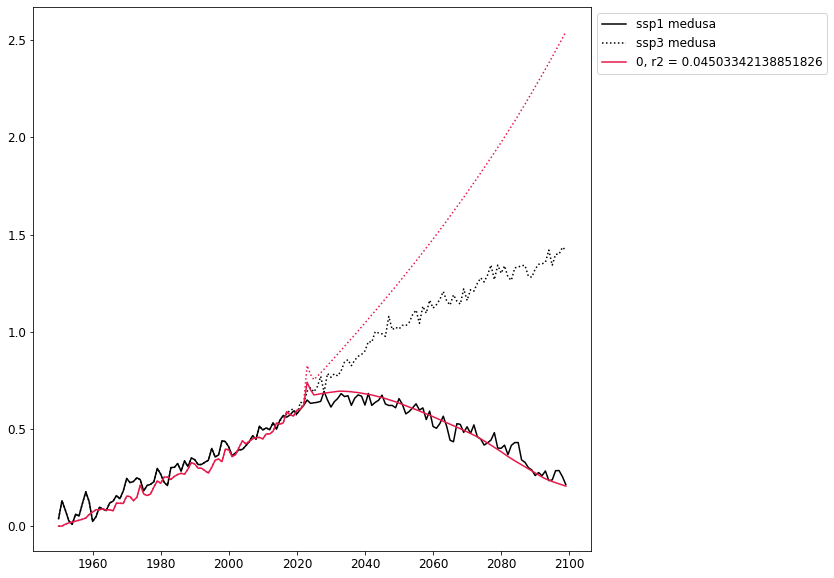

In [317]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP1_SO.csv'
file_path = oceansink
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
rocdat = df.Cflx.to_numpy()

oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP3_SO.csv'
file_path = oceansink
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
rocdat1 = df.Cflx.to_numpy()



cols = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', \
        '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', \
        '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000',\
        '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000'
]

df = pd.read_csv('./data/hildaoptimization_thirdpass.csv')
df_sorted = df.sort_values(by='rsum', ascending=True)
df_loc = df_sorted.head(50)


def get_ocfit(rocdat,ra0,ra1,ra2,ra3,rt1,rt2,rt3):

    obf = np.zeros(jit + 1)  # Adding 1 since Fortran arrays are 1-indexed
    abf = np.zeros(jit + 1)
    ocfit = np.zeros(jit + 1)
    ocfit1 = np.zeros(jit + 1)
    
    for it in range(1, jit + 1):  # Adjusting for Python's 0-indexing
        rit = float(it)
        abf[it] = ra0 + ra1 * np.exp(-rit / rt1) + ra2 * np.exp(-rit / rt2) + ra3 * np.exp(-rit / rt3)

        if it > 1:
            obf[it] = abf[it - 1] - abf[it]
        else:
            obf[it] = 1. - abf[it]

        ocfit[it] = 0
        ocfit1[it] = 0
        for jt in range(1, it + 1):
            ocfit[it] += pulse0[jt - 1] * obf[it - jt + 1] 
            ocfit1[it] += pulse1[jt - 1] * obf[it - jt + 1] 

    # Calculate RMSE
    rsum = np.sum((rocdat[:jdat] - ocfit[:jdat]) ** 2)
    rsum = rmse(ocfit[:jdat], rocdat[:jdat])
    #print(rsum)

    return ocfit, ocfit1, rsum

ra0 = df_loc['ra0'].to_numpy()
ra1 = df_loc['ra1'].to_numpy()
ra2 = df_loc['ra2'].to_numpy()
ra3 = df_loc['ra3'].to_numpy()
rt1 = df_loc['rt1'].to_numpy()
rt2 = df_loc['rt2'].to_numpy()
rt3 = df_loc['rt3'].to_numpy()


plt.figure(figsize = (10,10))
plt.plot(time,rocdat[0:150], color = 'k', label = 'ssp1 medusa')
plt.plot(time,rocdat1[0:150], color = 'k', linestyle = ':', label = 'ssp3 medusa')
for ind in range(0,1):
    ocfit0, ocfit1, rsum = get_ocfit(rocdat,ra0[ind],ra1[ind],ra2[ind],ra3[ind],rt1[ind],rt2[ind],rt3[ind])
    
    udif = ocfit1[149] - ocfit0[149]  
    udifroc = ocfit1[149] - rocdat1[149] 
    print(f'index {ind}: r2 {rsum}, 2100 ssp3-ssp1 PR:{udif}, ssp3_PR-ssp3_MED: {udifroc}')
    
    plt.plot(time,ocfit0[0:150], label = f'{ind}, r2 = {rsum}', color = cols[ind])
    plt.plot(time,ocfit1[0:150], linestyle = ':', color = cols[ind])
        
plt.legend(bbox_to_anchor = [1,1])

### let's calculate co2 responses (full year only, ssp1, ssp3, fixed ozone)

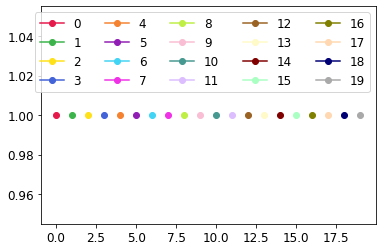

In [319]:
cols = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', \
        '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', \
        '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000',\
        '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000'
]


plt.figure()
for i in range(0,20):
    plt.plot(i,1,marker='o', color = cols[i], label = f'{i}')
plt.legend(ncol=5)

In [320]:
ds = xr.open_dataset('./data/BOE-inputs/BOE-OUTPUT-OBS.nc')

def get_efs(ds, p, sc, s, f):
    CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                  'forcing': f, 'scenario': sc }]
    CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                  'forcing': f, 'scenario': sc }] 
    CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                  'forcing': f, 'scenario': sc }] 
    CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                  'forcing': f, 'scenario': sc }] 
    CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                  'forcing': f, 'scenario': sc }]
    
    CO2_SST = 1* CO2_SST.values
    CO2_OT_phys_chem = 1* CO2_OT_phys_chem.values
    CO2_MLD_phys_chem = 1* CO2_MLD_phys_chem.values
    CO2_MLD_bio = 1* CO2_MLD_bio.values
    CO2_OT_bio = 1* CO2_OT_bio.values
    
    return CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio

from matplotlib.patches import Rectangle 

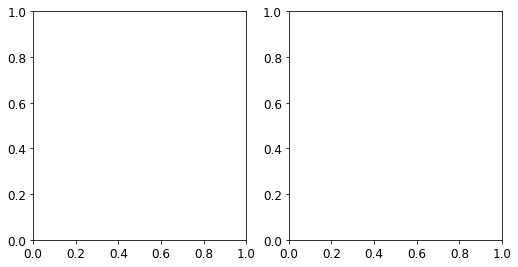

In [321]:
from matplotlib.patches import Rectangle 
fact = 0.7
fig, axs = plt.subplots(1,2, figsize=(12*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

pure_c = 9
effect_nl = 2
effect_cchem = 3
final_c = 4

wr = 0.5 #width of rectangle
ib = 0.1 #in between rectangles

def make_cascade(pure_c, effect_sst, effect_ot, effect_mld, effect_bio,\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = 0 ):
    
    cols = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', \
        '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', \
        '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000',\
        '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000'
    ]
    
    placs = []
    nrec = 0; plac = (ib+wr)*nrec + wr/2; placs.append(plac)
    axs[ind].add_patch( Rectangle((0+(ib+wr)*nrec, 0), wr, pure_c, fc ='k',  ec =cols[0], lw = 0)) 

    
    nrec = 1; plac = (ib+wr)*nrec + wr/2; placs.append(plac)
    axs[ind].add_patch(Rectangle((0+(ib+wr)*nrec, pure_c-effect_sst), wr, effect_sst, \
                            fc =cols[3])) 
                       

    
    nrec = 2; plac = (ib+wr)*nrec + wr/2; placs.append(plac)
    axs[ind].add_patch(Rectangle((0+(ib+wr)*nrec, pure_c-effect_sst-effect_ot), wr, effect_ot, \
                            fc =cols[0], ec =cols[2], lw = 0) )

    nrec = 3; plac = (ib+wr)*nrec + wr/2; placs.append(plac)
    axs[ind].add_patch(Rectangle((0+(ib+wr)*nrec, pure_c-effect_sst-effect_ot-effect_mld), wr, effect_mld, \
                            fc =cols[2], ec =cols[2], lw = 0) )
    
    nrec = 4; plac = (ib+wr)*nrec + wr/2; placs.append(plac)
    axs[ind].add_patch(Rectangle((0+(ib+wr)*nrec, pure_c-effect_sst-effect_ot-effect_mld-effect_bio), \
                                 wr, effect_bio, \
                            fc =cols[1], ec =cols[2], lw = 0) )   
    nrec = 5; plac = (ib+wr)*nrec + wr/2; placs.append(plac)
    
    effect_tot = effect_sst + effect_ot + effect_mld + effect_bio
    axs[ind].add_patch(Rectangle((0+(ib+wr)*nrec, pure_c-effect_tot), \
                                 wr/4, effect_tot, \
                            fc =cols[16], ec =cols[2], lw = 0) )  

    tdiff = (pure_c - final_c)
    effect_tot = effect_sst + effect_ot + effect_mld + effect_bio
    axs[ind].add_patch(Rectangle((0+(ib+wr)*nrec+wr/2, pure_c-tdiff), \
                                 wr/4, tdiff, \
                            fc ='k', ec =cols[2], lw = 0) ) 
#     tdiff = (pure_c - final_c)
#     axs[ind].add_patch(Rectangle((0+(ib+wr)*nrec+wr/2, pure_c - (pure_c-final_c), \
#                                  wr/4, effect_tot, \
#                             fc =cols[16], ec =cols[2], lw = 0) )   
                       
    nrec = 6; plac = (ib+wr)*nrec + wr/2; placs.append(plac)
    axs[ind].add_patch(Rectangle((0+(ib+wr)*nrec, 0), wr, final_c, \
                            fc =cols[19], ec =cols[3], lw = 0) )

    
    
    
    return placs

#placs = make_cascade(pure_c, effect_nl, effect_cchem, final_c, tf = 'r', wr = 1.3, ib = 0.1, ind = 0 )
#make_cascade(pure_c*2, effect_nl, effect_cchem, final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = 1 )    
# for i in range(0,2):
    
#     labs = ['$CO_2$','cchem', 'temp', 'final' ]
#     axs[i].set_ylim([0,10])
#     axs[i].set_xlim([-0.5,6])
#     axs[i].set_xticks(placs)
#     axs[i].set_xticklabels(labs)
# axs[0].add_patch( Rectangle((0.5, 0.5), 
#                         3, 2, 
#                         fc ='y',  
#                         ec ='y', 
#                         lw = 5,
#                         angle = 60) ) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


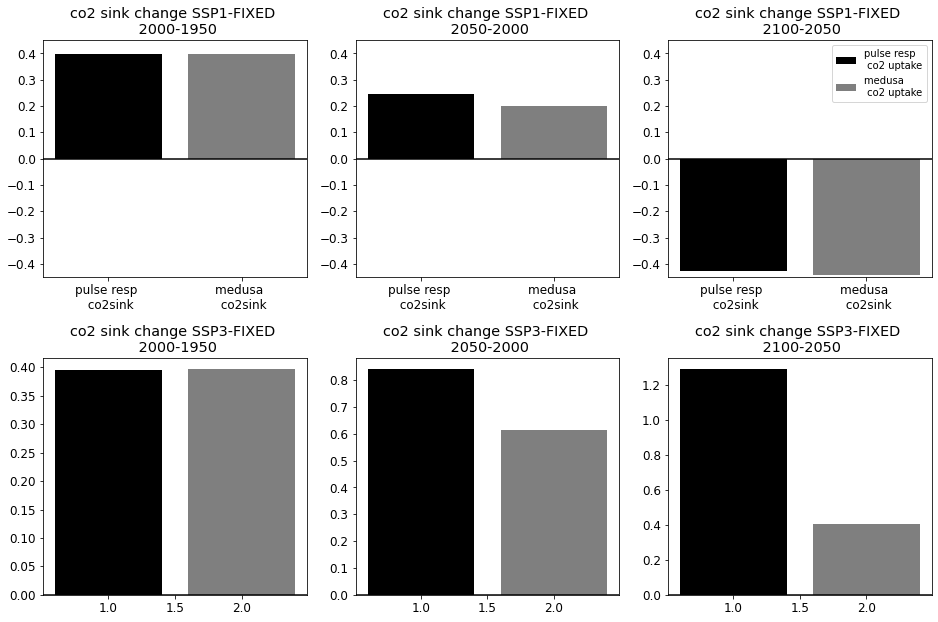

In [322]:
ds = xr.open_dataset('./data/BOE-inputs/BOE-OUTPUT-OBS.nc')
fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

medusa_change = np.zeros(6)
pr_change = np.zeros(6)

for i in range(0,3):
    
    
    
    
    
    axs[i].bar(1,(ocfit0[50*(i+1)-1]-ocfit0[50*(i)]), color = 'k', alpha = 1, label = 'pulse resp \n co2 uptake')
    axs[i].bar(2,(rocdat[50*(i+1)-1]-rocdat[50*(i)]), color = 'k', alpha = 0.5, label = 'medusa \n co2 uptake')
    

    
    axs[i].set_ylim([-0.45,0.45])
    axs[2].legend(loc = 'best', fontsize = 10)
    
    axs[i+3].bar(1,(ocfit1[50*(i+1)-1]-ocfit1[50*(i)]), color = 'k', alpha = 1)
    axs[i+3].bar(2,(rocdat1[50*(i+1)-1]-rocdat1[50*(i)]), color = 'k', alpha = 0.5)
    
    pr_change[i] = ocfit0[50*(i+1)-1]-ocfit0[50*(i)]
    medusa_change[i] = rocdat[50*(i+1)-1]-rocdat[50*(i)]
    pr_change[i+3] = ocfit1[50*(i+1)-1]-ocfit0[50*(i)]
    medusa_change[i+3] = rocdat1[50*(i+1)-1]-rocdat[50*(i)]
    
    axs[i].set_xticks(np.arange(1,3))
    axs[i].set_xticklabels(['pulse resp \n co2sink', 'medusa \n co2sink'])
    
tits = ['co2 sink change SSP1-FIXED \n 2000-1950','co2 sink change SSP1-FIXED \n 2050-2000',
       'co2 sink change SSP1-FIXED \n 2100-2050',
       'co2 sink change SSP3-FIXED \n 2000-1950','co2 sink change SSP3-FIXED \n 2050-2000',
       'co2 sink change SSP3-FIXED \n 2100-2050']
for i in range(0,6):
    axs[i].set_title(tits[i])
    axs[i].axhline(y= 0, color = 'k')
    
plt.tight_layout()


1.45856542224424
[0.25, 0.85, 1.45, 2.05, 2.65, 3.25, 3.8499999999999996]


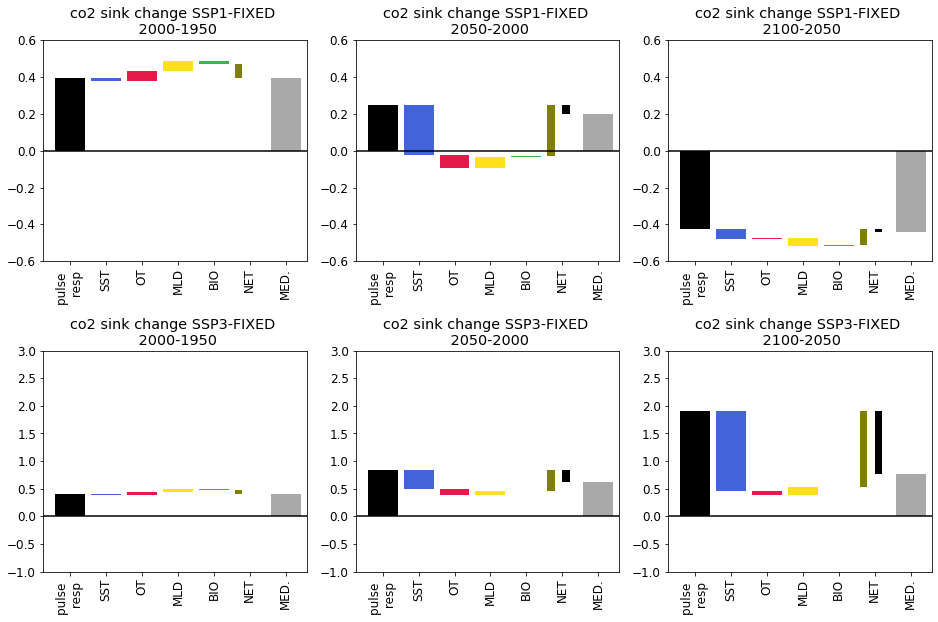

In [323]:
ds = xr.open_dataset('./data/BOE-inputs/BOE-OUTPUT-OBS.nc')
periodar = ['1950-2000','2000-2050','2050-2100']
s = 'FY'; f = 'ghg'
p = periodar[0]
sc = 'ssp1'


fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ind = 0; p = periodar[0]; sc = 'ssp1'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)

pure_c = pr_change[ind]; final_c = medusa_change[ind]
placs = make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

ind = 1; p = periodar[1]; sc = 'ssp1'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)

pure_c = pr_change[ind]; final_c = medusa_change[ind]
make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

ind = 2; p = periodar[2]; sc = 'ssp1'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)
pure_c = pr_change[ind]; final_c = medusa_change[ind]
make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

###
ind = 3; p = periodar[0]; sc = 'ssp3'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)

pure_c = pr_change[ind]; final_c = medusa_change[ind]
make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

ind = 4; p = periodar[1]; sc = 'ssp3'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)

pure_c = pr_change[ind]; final_c = medusa_change[ind]
make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

ind = 5; p = periodar[2]; sc = 'ssp3'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)
print(CO2_SST)
pure_c = pr_change[ind]; final_c = medusa_change[ind]
make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

print(placs)
labs = ['pulse \n resp', 'SST','OT','MLD','BIO','NET','MED.']

for i in range(0,6):
    axs[i].set_xlim([-0.2,4.2])
    axs[i].set_ylim([-1,3])
    axs[i].axhline(y= 0, color = 'k')
    axs[i].set_xticks(placs)
    axs[i].set_xticklabels(labs, rotation = 90)
for i in range(0,3):
    axs[i].set_ylim([-0.6,0.6])
    
tits = ['co2 sink change SSP1-FIXED \n 2000-1950','co2 sink change SSP1-FIXED \n 2050-2000',
       'co2 sink change SSP1-FIXED \n 2100-2050',
       'co2 sink change SSP3-FIXED \n 2000-1950','co2 sink change SSP3-FIXED \n 2050-2000',
       'co2 sink change SSP3-FIXED \n 2100-2050']
for i in range(0,6):
    axs[i].set_title(tits[i])


plt.tight_layout()

0.00040457188038153785
[0.25, 0.85, 1.45, 2.05, 2.65, 3.25, 3.8499999999999996]


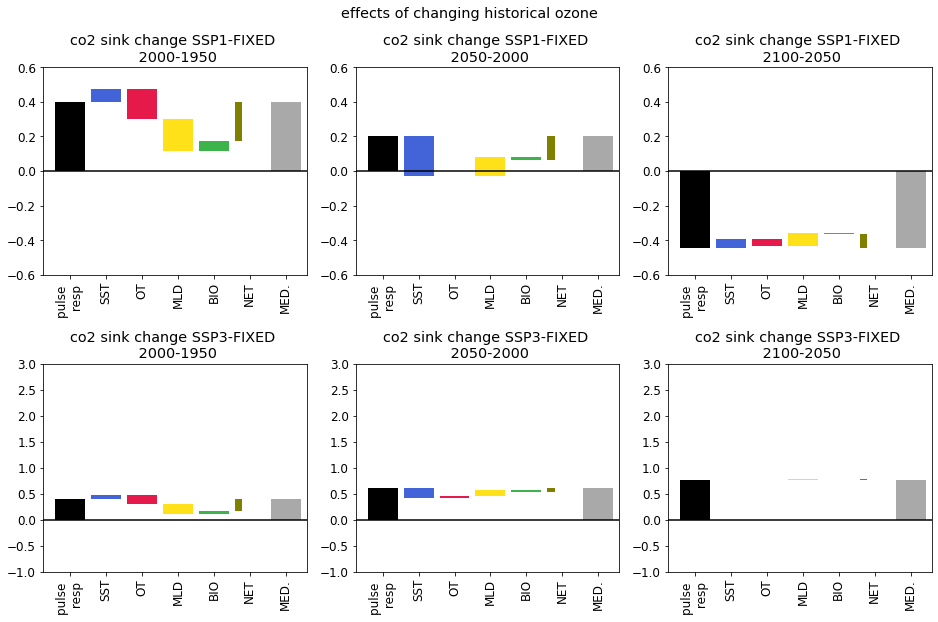

In [324]:
ds = xr.open_dataset('./data/BOE-inputs/BOE-OUTPUT-OBS.nc')
periodar = ['1950-2000','2000-2050','2050-2100']
s = 'FY'; f = 'ozone'
p = periodar[0]
sc = 'ssp1'


fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ind = 0; p = periodar[0]; sc = 'ssp1'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)

pure_c = medusa_change[ind]; final_c = medusa_change[ind]
placs = make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

ind = 1; p = periodar[1]; sc = 'ssp1'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)

pure_c = medusa_change[ind]; final_c = medusa_change[ind]
make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

ind = 2; p = periodar[2]; sc = 'ssp1'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)
pure_c = medusa_change[ind]; final_c = medusa_change[ind]
make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

###
ind = 3; p = periodar[0]; sc = 'ssp3'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)

pure_c = medusa_change[ind]; final_c = medusa_change[ind]
make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

ind = 4; p = periodar[1]; sc = 'ssp3'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)

pure_c = medusa_change[ind]; final_c = medusa_change[ind]
make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

ind = 5; p = periodar[2]; sc = 'ssp3'
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = get_efs(ds, p, sc, s, f)
print(CO2_SST)
pure_c = medusa_change[ind]; final_c = medusa_change[ind]
make_cascade(pure_c, CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, (CO2_OT_bio+CO2_MLD_bio),\
                 final_c, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )

print(placs)
labs = ['pulse \n resp', 'SST','OT','MLD','BIO','NET','MED.']

for i in range(0,6):
    axs[i].set_xlim([-0.2,4.2])
    axs[i].set_ylim([-1,3])
    axs[i].axhline(y= 0, color = 'k')
    axs[i].set_xticks(placs)
    axs[i].set_xticklabels(labs, rotation = 90)
for i in range(0,3):
    axs[i].set_ylim([-0.6,0.6])
    
tits = ['co2 sink change SSP1-FIXED \n 2000-1950','co2 sink change SSP1-FIXED \n 2050-2000',
       'co2 sink change SSP1-FIXED \n 2100-2050',
       'co2 sink change SSP3-FIXED \n 2000-1950','co2 sink change SSP3-FIXED \n 2050-2000',
       'co2 sink change SSP3-FIXED \n 2100-2050']
for i in range(0,6):
    axs[i].set_title(tits[i])

plt.suptitle('effects of changing historical ozone')
plt.tight_layout()

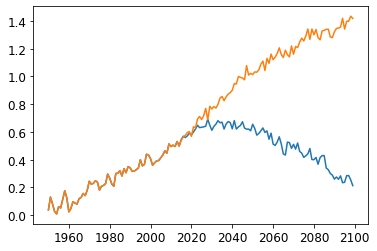

In [325]:
atmoco2_SSP1 = './data/csvs/atmco2-SSP1.csv'
file_path = atmoco2_SSP1
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify it's loaded correctly
time = df.year.to_numpy()
atm = df.atmco2.to_numpy()
pulse0 = np.zeros_like(atm)

# print(atm[0])
for i in range(1,len(pulse0)):
    pulse0[i] = (atm[i] - atm[i-1]) * 2.123 #gcb, table1


oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP1_SO.csv'
file_path = oceansink
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
rocdat = df.Cflx.to_numpy()

oceansink = './data/csvs/Cflx-Pgyr-ozoneFIXED-SSP3_SO.csv'
file_path = oceansink
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)
rocdat1 = df.Cflx.to_numpy()

plt.figure()
plt.plot(time,rocdat)
plt.plot(time,rocdat1)

## optimisation in terms of DIC

In [346]:
s1A = xr.open_dataset('./data/cchem_averages_scen_1A.nc')
s1B = xr.open_dataset('./data/cchem_averages_scen_1B.nc')

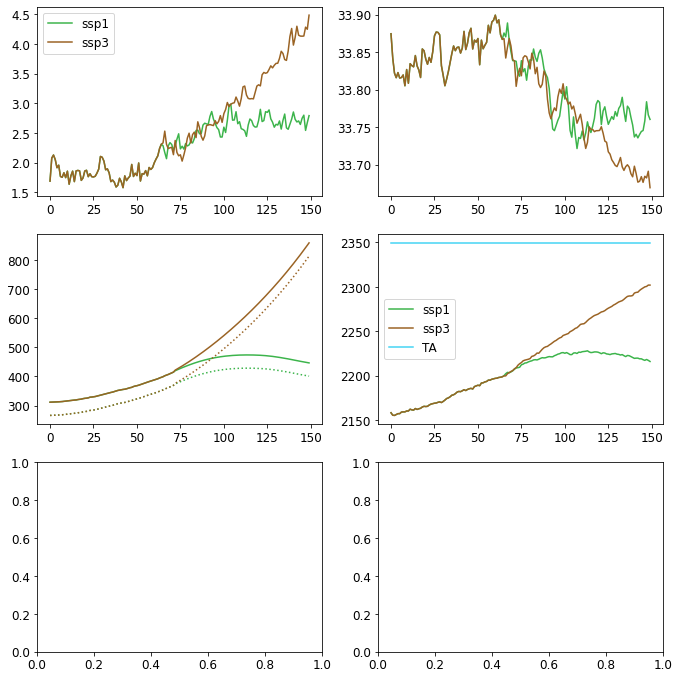

In [347]:
dpco2 = 45.42591669433892

fact = 0.8
fig, axs = plt.subplots(3,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(s1A.year,s1A.T_ts, label = 'ssp1', color = cols[1])
axs[0].plot(s1A.year,s1B.T_ts, label = 'ssp3', color = cols[12])
axs[0].legend(loc = 'best')
axs[1].plot(s1A.year,s1A.S_ts, label = 'ssp1', color = cols[1])
axs[1].plot(s1A.year,s1B.S_ts, label = 'ssp3', color = cols[12])

axs[2].plot(s1A.year,s1A.co2_atm, label = 'ssp1', color = cols[1])
axs[2].plot(s1A.year,s1B.co2_atm, label = 'ssp3', color = cols[12])
axs[2].plot(s1A.year,s1A.co2_ocean,linestyle = ':' , label = 'ssp1', color = cols[1])
axs[2].plot(s1A.year,s1B.co2_ocean,linestyle = ':' , label = 'ssp3', color = cols[12])

axs[3].plot(s1A.year,s1A.DIC_glodap, label = 'ssp1', color = cols[1])
axs[3].plot(s1A.year,s1B.DIC_glodap, label = 'ssp3', color = cols[12])
axs[3].plot(s1A.year,s1B.ALK_glodap, label = 'TA', color = cols[6])
axs[3].legend(loc = 'best')



plt.tight_layout()

In [348]:
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/mocsy-master')
import mocsy
import gsw

def get_revelle(DIC_mean, TA_mean, T_mean, S_mean):
    

    votemper = T_mean
    vosaline = S_mean
    
    tdra = (DIC_mean * 1e-3) #DIC, convert umol/L to mol/m3 (1000 L/m3)
    ttara = (TA_mean * 1e-3) #Alkalinity, convert umol/L to mol/m3 (1000 L/m3)
    tsra = (vosaline) #salt
    tsra_psu = (vosaline) *35/35.16504 #g/kg to psu (salt)
    ttera = (votemper)

    tdepth = np.zeros_like(ttera)
    tdepth = 0
    ttera_is = gsw.t_from_CT(tsra,ttera,tdepth)
    tzero = np.zeros_like(tdepth)
    tpressure = np.zeros_like(tdepth)


    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    return pco2, BetaD

pco2, BetaD = get_revelle(2000,2100,2,32)
print(pco2[0])
print(BetaD[0])

revelle_1A = np.zeros_like(s1A.DIC_glodap.values)
revelle_1B = np.zeros_like(s1A.DIC_glodap.values)
for i in range(0,150):
    pco2, BetaD = get_revelle(s1A.DIC_glodap[i],s1A.ALK_glodap[i],s1A.T_ts[i],s1A.S_ts[i])
    revelle_1A[i] = (BetaD[0])
revelle_1B = np.zeros_like(s1B.DIC_glodap.values)
for i in range(0,150):
    pco2, BetaD = get_revelle(s1B.DIC_glodap[i],s1B.ALK_glodap[i],s1B.T_ts[i],s1B.S_ts[i])
    revelle_1B[i] = (BetaD[0])

s1A['revelle'] = s1A['T_ts'].copy(deep=True)
s1A['revelle'][:] = revelle_1A
s1B['revelle'] = s1B['T_ts'].copy(deep=True)
s1B['revelle'][:] = revelle_1B

399.15593678292225
15.833489868452807


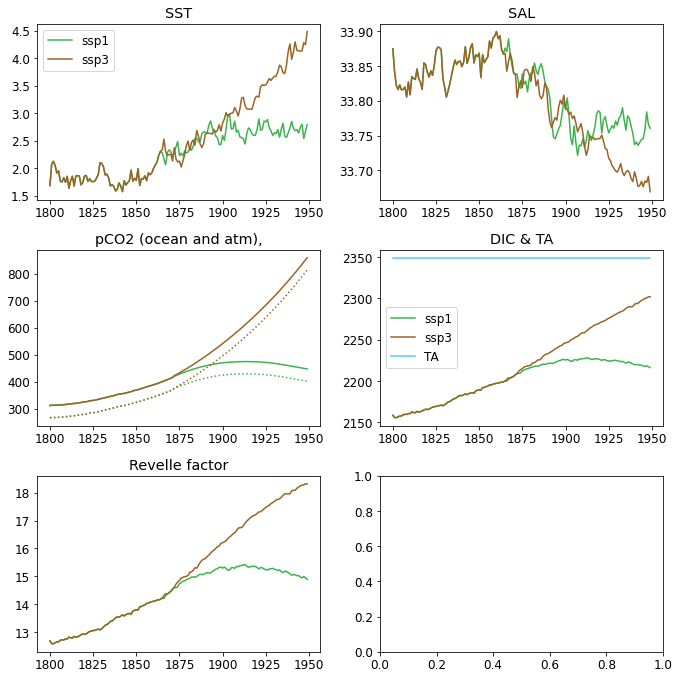

In [349]:
dpco2 = 45.42591669433892

fact = 0.8
fig, axs = plt.subplots(3,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(s1A.year+1800,s1A.T_ts, label = 'ssp1', color = cols[1])
axs[0].plot(s1A.year+1800,s1B.T_ts, label = 'ssp3', color = cols[12])
axs[0].legend(loc = 'best')
axs[1].plot(s1A.year+1800,s1A.S_ts, label = 'ssp1', color = cols[1])
axs[1].plot(s1A.year+1800,s1B.S_ts, label = 'ssp3', color = cols[12])

axs[2].plot(s1A.year+1800,s1A.co2_atm, label = 'ssp1', color = cols[1])
axs[2].plot(s1A.year+1800,s1B.co2_atm, label = 'ssp3', color = cols[12])
axs[2].plot(s1A.year+1800,s1A.co2_ocean,linestyle = ':' , label = 'ssp1', color = cols[1])
axs[2].plot(s1A.year+1800,s1B.co2_ocean,linestyle = ':' , label = 'ssp3', color = cols[12])

axs[3].plot(s1A.year+1800,s1A.DIC_glodap, label = 'ssp1', color = cols[1])
axs[3].plot(s1A.year+1800,s1B.DIC_glodap, label = 'ssp3', color = cols[12])
axs[3].plot(s1A.year+1800,s1B.ALK_glodap, label = 'TA', color = cols[6])
axs[3].legend(loc = 'best')

axs[4].plot(s1A.year+1800,s1A.revelle, label = 'ssp1', color = cols[1])
axs[4].plot(s1A.year+1800,s1B.revelle, label = 'ssp3', color = cols[12])
axs[3].legend(loc = 'best')

tits = ['SST', 'SAL','pCO2 (ocean and atm),', 'DIC & TA', 'Revelle factor']
for i in range(0,5):
    axs[i].set_title(tits[i])
plt.tight_layout()

In [350]:
def get_DIC_from_pCO2(S,T, t_pCO2, ALK = 2349.51722732, verbose = False):
    
    
    tdra = np.arange(2050,2400,0.25) * 1e-3
    ttara = np.zeros_like(tdra)
    ttara[:] = ALK * 1e-3
    
    tsra = np.zeros_like(tdra)
    ttera = np.zeros_like(tdra)
    
    tsra[:] = S
    ttera[:] = T
    
    tsra_psu = np.ravel(tsra) *35/35.16504 #g/kg to psu (salt)
    ttera = np.ravel(ttera)
    tdepth = np.zeros_like(ttera)
    tdepth[:] = 0
    ttera_is = gsw.t_from_CT(tsra,ttera,tdepth)
    tzero = np.zeros_like(tdepth)
    tpressure = np.zeros_like(tdepth)
    
    if verbose:
        print(ttera_is[0])
        print(tsra_psu[0])

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    
    nearest_pco2 = np.min(np.abs(pco2-t_pCO2))
    ind_closest = (np.where((np.abs(pco2-t_pCO2)) == nearest_pco2 ))
    if verbose:
        print(f'DIC is: {tdra[ind_closest]*1e3}')
        print(t_pCO2)
        print(pco2[ind_closest])
        
    tDIC = tdra[ind_closest]*1e3
    tDIC = tDIC[0]
        
    return tDIC

def get_SST_effect(S,T, delT, t_pCO2, ALK = 2349.51722732, verbose = False):

    DIC1 = get_DIC_from_pCO2(S,T, t_pCO2, ALK = 2349.51722732, verbose = False)
    tpCO2_2 = t_pCO2*0.04*delT+ t_pCO2
    DIC2 = get_DIC_from_pCO2(S,T,tpCO2_2, ALK = 2349.51722732, verbose = False)
    diff = DIC2-DIC1
    
    return DIC1, DIC2, diff

def get_dics(yind,ds):
    DIC = ds.DIC_glodap.isel(year = yind - 1950)
    oce_pco2 = ds.co2_ocean.isel(year = yind - 1950)
    R = ds.revelle.isel(year = yind - 1950)
    del_pco2 = ds.co2_ocean.isel(year = yind + 49 - 1950) - ds.co2_ocean.isel(year = yind - 1950)

    delDIC = (1/R)* (del_pco2 / oce_pco2) * DIC
    delDIC_glodap = ds.DIC_glodap.isel(year = yind+49 - 1950) - ds.DIC_glodap.isel(year = yind - 1950)
    
    return delDIC, delDIC_glodap

def get_sst_DIC(yind,ds):
    DIC = ds.DIC_glodap.isel(year = yind - 1950).values
    oce_pco2 = ds.co2_ocean.isel(year = yind - 1950).values
    T = ds.T_ts.isel(year = yind - 1950).values
    S = ds.S_ts.isel(year = yind - 1950).values
    delT = ds.T_ts.isel(year = yind + 49 - 1950).values - ds.T_ts.isel(year = yind - 1950).values
    DIC1, DIC2, diff = get_SST_effect(S,T, delT, oce_pco2, ALK = 2349.51722732, verbose = False)

    
    return diff

diff = get_sst_DIC(2050,s1B)
print(diff)

tds = xr.open_dataset('./data/BOE-inputs/BOE-OUTPUT-OBS-experimental-umolL.nc')

def get_efs_umolL(ds, p, sc, s, f):
    SO_area = 4.67e13
    
    CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                  'forcing': f, 'scenario': sc }]
    CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                  'forcing': f, 'scenario': sc }] 
    CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                  'forcing': f, 'scenario': sc }] 
    CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                  'forcing': f, 'scenario': sc }] 
    CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                  'forcing': f, 'scenario': sc }]
    
    CO2_SST = 1* CO2_SST.values
    CO2_OT_phys_chem = 1* CO2_OT_phys_chem.values
    CO2_MLD_phys_chem = 1* CO2_MLD_phys_chem.values
    CO2_MLD_bio = 1* CO2_MLD_bio.values
    CO2_OT_bio = 1* CO2_OT_bio.values
    
    CO2_OT_phys_chem = CO2_OT_phys_chem/1e3/SO_area
    CO2_OT_bio = CO2_OT_bio/1e3/SO_area
    
    return CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio

CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = \
get_efs_umolL(tds, '1950-2000', 'ssp3', 'FY', 'ozone')




# CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = \
# get_efs(tds, '1950-2000', 'ssp1', 'FY', 'ghg')
# print(CO2_MLD_phys_chem)

8.75


In [345]:
delDIC, delDIC_glodap = get_dics(1950,s1A)
delDIC

<xarray.DataArray ()>
array(267.03588313)
Coordinates:
    time_counter  int64 1950

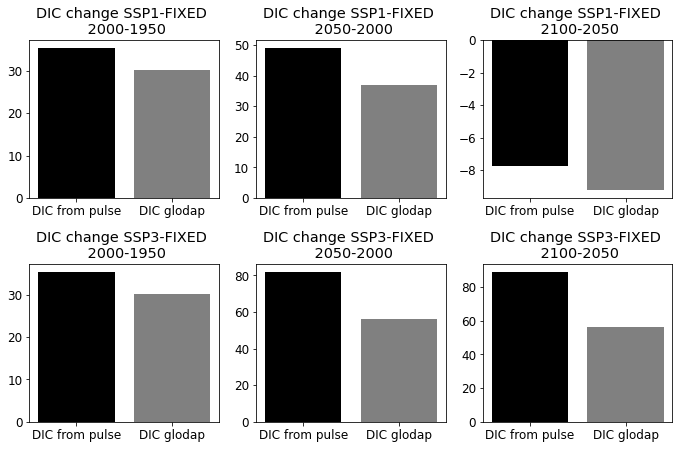

In [351]:

fact = 0.8
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

delDIC, delDIC_glodap = get_dics(1950,s1A)
axs[0].bar(0,delDIC, color = 'k')
axs[0].bar(1,delDIC_glodap, color = 'grey')

delDIC, delDIC_glodap = get_dics(2000,s1A)
axs[1].bar(0,delDIC, color = 'k')
axs[1].bar(1,delDIC_glodap, color = 'grey')

delDIC, delDIC_glodap = get_dics(2050,s1A)
axs[2].bar(0,delDIC, color = 'k')
axs[2].bar(1,delDIC_glodap, color = 'grey')

delDIC, delDIC_glodap = get_dics(1950,s1B)
axs[3].bar(0,delDIC, color = 'k')
axs[3].bar(1,delDIC_glodap, color = 'grey')

delDIC, delDIC_glodap = get_dics(2000,s1B)
axs[4].bar(0,delDIC, color = 'k')
axs[4].bar(1,delDIC_glodap, color = 'grey')

delDIC, delDIC_glodap = get_dics(2050,s1B)
axs[5].bar(0,delDIC, color = 'k')
axs[5].bar(1,delDIC_glodap, color = 'grey')


tits = ['DIC change SSP1-FIXED \n 2000-1950','DIC change SSP1-FIXED \n 2050-2000',
       'DIC change SSP1-FIXED \n 2100-2050',
       'DIC change SSP3-FIXED \n 2000-1950','DIC change SSP3-FIXED \n 2050-2000',
       'DIC change SSP3-FIXED \n 2100-2050']

for i in range(0,6):
    axs[i].set_title(tits[i])
    axs[i].set_xticks([0,1])
    axs[i].set_xticklabels(['DIC from pulse','DIC glodap'])
    
plt.tight_layout()

1950-2000 ssp1 FY ghg
diff between dic from pulse and dic from glodap = 5.218813249795296
effect sst 0.7500000000004547, effect ot -9.211819502464329e-05 effect mld -0.8663711874344977 effect bio 0.1273920804133065
sum of effects 0.010928774784238898

2000-2050 ssp1 FY ghg
diff between dic from pulse and dic from glodap = 12.362814402302035
effect sst 4.0, effect ot 0.00011952233168119672 effect mld -0.6125161216111852 effect bio 0.10471392619177858
sum of effects 3.492317326912274

2050-2100 ssp1 FY ghg
diff between dic from pulse and dic from glodap = 1.4814017121219667
effect sst 1.25, effect ot -1.7025777029140247e-05 effect mld 0.4529682827115937 effect bio -0.08241013147164367
sum of effects 1.620541125462921

1950-2000 ssp3 FY ghg
diff between dic from pulse and dic from glodap = 5.218813249795296
effect sst 0.7500000000004547, effect ot -9.211819502464329e-05 effect mld -0.8663711874344977 effect bio 0.1273920804133065
sum of effects 0.010928774784238898

2000-2050 ssp3 FY ghg


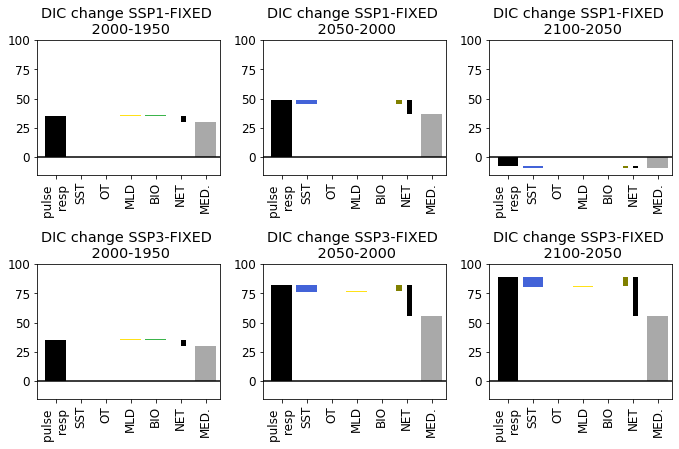

In [352]:
fact = 0.8
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

ind = 0
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = \
get_efs_umolL(tds, '1950-2000', 'ssp1', 'FY', 'ghg')
delDIC, delDIC_glodap = get_dics(1950,s1A)
effect_sst = get_sst_DIC(1950,s1A);
effect_ot = CO2_OT_phys_chem; effect_mld = CO2_MLD_phys_chem; effect_bio = CO2_OT_bio + CO2_MLD_bio
placs = make_cascade(delDIC, effect_sst, effect_ot, effect_mld, effect_bio,\
                 delDIC_glodap, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )
diff = (delDIC-delDIC_glodap).values
print('1950-2000 ssp1 FY ghg')
print(f'diff between dic from pulse and dic from glodap = {diff}')
print(f'effect sst {effect_sst}, effect ot {effect_ot} effect mld {effect_mld} effect bio {effect_bio}')
print(f'sum of effects {effect_sst+effect_ot+effect_mld+effect_bio}')
print()

ind = 1
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = \
get_efs_umolL(tds, '2000-2050', 'ssp1', 'FY', 'ghg')
delDIC, delDIC_glodap = get_dics(2000,s1A)
effect_sst = get_sst_DIC(2000,s1A);
effect_ot = CO2_OT_phys_chem; effect_mld = CO2_MLD_phys_chem; effect_bio = CO2_OT_bio + CO2_MLD_bio
placs = make_cascade(delDIC, effect_sst, effect_ot, effect_mld, effect_bio,\
                 delDIC_glodap, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )
diff = (delDIC-delDIC_glodap).values
print('2000-2050 ssp1 FY ghg')
print(f'diff between dic from pulse and dic from glodap = {diff}')
print(f'effect sst {effect_sst}, effect ot {effect_ot} effect mld {effect_mld} effect bio {effect_bio}')
print(f'sum of effects {effect_sst+effect_ot+effect_mld+effect_bio}')
print()

ind = 2
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = \
get_efs_umolL(tds, '2050-2100', 'ssp1', 'FY', 'ghg')
delDIC, delDIC_glodap = get_dics(2050,s1A)
effect_sst = get_sst_DIC(2050,s1A);
effect_ot = CO2_OT_phys_chem; effect_mld = CO2_MLD_phys_chem; effect_bio = CO2_OT_bio + CO2_MLD_bio
placs = make_cascade(delDIC, effect_sst, effect_ot, effect_mld, effect_bio,\
                 delDIC_glodap, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )
diff = (delDIC-delDIC_glodap).values
print('2050-2100 ssp1 FY ghg')
print(f'diff between dic from pulse and dic from glodap = {diff}')
print(f'effect sst {effect_sst}, effect ot {effect_ot} effect mld {effect_mld} effect bio {effect_bio}')
print(f'sum of effects {effect_sst+effect_ot+effect_mld+effect_bio}')
print()


ind = 0+3
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = \
get_efs_umolL(tds, '1950-2000', 'ssp3', 'FY', 'ghg')
delDIC, delDIC_glodap = get_dics(1950,s1B)
effect_sst = get_sst_DIC(1950,s1B);
effect_ot = CO2_OT_phys_chem; effect_mld = CO2_MLD_phys_chem; effect_bio = CO2_OT_bio + CO2_MLD_bio
placs = make_cascade(delDIC, effect_sst, effect_ot, effect_mld, effect_bio,\
                 delDIC_glodap, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )
diff = (delDIC-delDIC_glodap).values
print('1950-2000 ssp3 FY ghg')
print(f'diff between dic from pulse and dic from glodap = {diff}')
print(f'effect sst {effect_sst}, effect ot {effect_ot} effect mld {effect_mld} effect bio {effect_bio}')
print(f'sum of effects {effect_sst+effect_ot+effect_mld+effect_bio}')
print()

ind = 1+3
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = \
get_efs_umolL(tds, '2000-2050', 'ssp3', 'FY', 'ghg')
delDIC, delDIC_glodap = get_dics(2000,s1B)
effect_sst = get_sst_DIC(2000,s1B);
effect_ot = CO2_OT_phys_chem; effect_mld = CO2_MLD_phys_chem; effect_bio = CO2_OT_bio + CO2_MLD_bio
placs = make_cascade(delDIC, effect_sst, effect_ot, effect_mld, effect_bio,\
                 delDIC_glodap, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )
diff = (delDIC-delDIC_glodap).values
print('2000-2050 ssp3 FY ghg')
print(f'diff between dic from pulse and dic from glodap = {diff}')
print(f'effect sst {effect_sst}, effect ot {effect_ot} effect mld {effect_mld} effect bio {effect_bio}')
print(f'sum of effects {effect_sst+effect_ot+effect_mld+effect_bio}')
print()

ind = 2+3
CO2_SST, CO2_OT_phys_chem, CO2_MLD_phys_chem, CO2_MLD_bio, CO2_OT_bio = \
get_efs_umolL(tds, '2050-2100', 'ssp3', 'FY', 'ghg')
delDIC, delDIC_glodap = get_dics(2050,s1B)
effect_sst = get_sst_DIC(2050,s1B);
effect_ot = CO2_OT_phys_chem; effect_mld = CO2_MLD_phys_chem; effect_bio = CO2_OT_bio + CO2_MLD_bio
placs = make_cascade(delDIC, effect_sst, effect_ot, effect_mld, effect_bio,\
                 delDIC_glodap, tf = 'r', wr = 0.5, ib = 0.1, ind = ind )
diff = (delDIC-delDIC_glodap).values
print('2050-2100 ssp3 FY ghg')
print(f'diff between dic from pulse and dic from glodap = {diff}')
print(f'effect sst {effect_sst}, effect ot {effect_ot} effect mld {effect_mld} effect bio {effect_bio}')
print(f'sum of effects {effect_sst+effect_ot+effect_mld+effect_bio}')
print()


print(placs)
labs = ['pulse \n resp', 'SST','OT','MLD','BIO','NET','MED.']

for i in range(0,6):
    axs[i].set_xlim([-0.2,4.2])
    axs[i].set_ylim([-15,100])
    axs[i].axhline(y= 0, color = 'k')
    axs[i].set_xticks(placs)
    axs[i].set_xticklabels(labs, rotation = 90)
for i in range(0,3):
    axs[i].set_ylim([-15,100])
    
tits = ['DIC change SSP1-FIXED \n 2000-1950','DIC change SSP1-FIXED \n 2050-2000',
       'DIC change SSP1-FIXED \n 2100-2050',
       'DIC change SSP3-FIXED \n 2000-1950','DIC change SSP3-FIXED \n 2050-2000',
       'DIC change SSP3-FIXED \n 2100-2050']
for i in range(0,6):
    axs[i].set_title(tits[i])
    plt.tight_layout()

In [342]:
yind = 1950


fact = 0.8
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

delDIC, delDIC_glodap = get_dics(1950,s1A)
axs[0].bar(0,delDIC, color = 'k')
axs[0].bar(1,delDIC_glodap, color = 'grey')

delDIC, delDIC_glodap = get_dics(2000,s1A)
axs[1].bar(0,delDIC, color = 'k')
axs[1].bar(1,delDIC_glodap, color = 'grey')

delDIC, delDIC_glodap = get_dics(2050,s1A)
axs[2].bar(0,delDIC, color = 'k')
axs[2].bar(1,delDIC_glodap, color = 'grey')

delDIC, delDIC_glodap = get_dics(1950,s1B)
axs[3].bar(0,delDIC, color = 'k')
axs[3].bar(1,delDIC_glodap, color = 'grey')

delDIC, delDIC_glodap = get_dics(2000,s1B)
axs[4].bar(0,delDIC, color = 'k')
axs[4].bar(1,delDIC_glodap, color = 'grey')

delDIC, delDIC_glodap = get_dics(2050,s1B)
axs[5].bar(0,delDIC, color = 'k')
axs[5].bar(1,delDIC_glodap, color = 'grey')


tits = ['DIC change SSP1-FIXED \n 2000-1950','DIC change SSP1-FIXED \n 2050-2000',
       'DIC change SSP1-FIXED \n 2100-2050',
       'DIC change SSP3-FIXED \n 2000-1950','DIC change SSP3-FIXED \n 2050-2000',
       'DIC change SSP3-FIXED \n 2100-2050']

for i in range(0,6):
    axs[i].set_title(tits[i])
    axs[i].set_xticks([0,1])
    axs[i].set_xticklabels(['DIC from pulse','DIC glodap'])
    
plt.tight_layout()

NameError: name 'S' is not defined

In [343]:
s1A['revelle'] = s1A['T_ts'].copy(deep=True)

In [335]:
def effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area):
    
    dfco2 = mn_kg*0.04*mn_pCO2*sst_delta #dfCO2 = kg(4%-pCO2/degree x dSST)
    dfco2_pgCyr_SST = dfco2 * PgC_mol * SO_area #dfCO2 in PgC/yr
    
    dfco2_pgCyr_SST = np.nan
    
    return dfco2_pgCyr_SST

def effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio):
    #dic
    dDIC = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_MLD_DIC = dfCO2_DIC * PgC_mol * SO_area 

    ##ta
    dTA = dDIC * (-1/3)
    dfcCO2_TA = (-1/3)*dfCO2_DIC
    dfco2_pgCyr_MLD_TA = dfcCO2_TA * PgC_mol * SO_area 

    #iron (ecosystem)
    dFe = mld_delta *  grad_dFedz #dFe = dMLD x dFe/dz 
    #print(dFe)
    dDIC_fe = -1 * dmudFe * dFe * mu_L * diatconc * 365.25 * efratio#dDIC = -dmu/dFe x dFe x mu_L x DIA x dtime  
    
    dpCO2_Fe = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_fe  #dpCO2 = R x pCO2/DIC x dDIC
    #print(dpCO2_Fe)
    dfCO2_Fe = mn_kg * dpCO2_Fe
    #print(dfCO2_Fe)
    dfco2_pgCyr_MLD_Fe = dfCO2_Fe * PgC_mol * SO_area
    #print(dfco2_pgCyr_MLD_Fe)

    return dDIC, dTA, dDIC_fe


def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio):

    dfco2_pgCyr_OT_DIC = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001## in mols*0.000000000000012 #dfCO2_DIC = dOverturning x (dDICv)
    dfco2_pgCyr_OT_TA = -(1/3)*dfco2_pgCyr_OT_DIC #dfCO2_TA = -1/3 x dfCO2_DIC
    #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dfco2_pgCyr_OT_Fe = dDICv * ot_delta * 1e6 * 1000*31560000*0.000001## in mols*0.000000000000012 # dfCO2_DIC = dOverturning x (dDIC)

    return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe

    
    #dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    if verbose:
        print('*******')
        print(f'ot delta {ot_delta}')
        print(f'DIC ef pgC/yr: {dfco2_pgCyr_OT_DIC} TA ef pgC/yr {dfco2_pgCyr_OT_TA}')
        print(f'ecosystem pgC/yr: {dfco2_pgCyr_OT_Fe}')
        print('*******')
    
    return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe



def give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                    mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = False): 

    dfco2_pgCyr_SST  = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)

    dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = \
        effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area, grad_dFedz, dmudFe, mu_L, diatconc, efratio)

    dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = \
    effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio)
    
    CO2_SST = dfco2_pgCyr_SST
    CO2_MLD_phys_chem = dfco2_pgCyr_MLD_TA + dfco2_pgCyr_MLD_DIC
    CO2_OT_phys_chem = dfco2_pgCyr_OT_TA + dfco2_pgCyr_OT_DIC
    CO2_OT_MLD_bio = dfco2_pgCyr_OT_Fe + dfco2_pgCyr_MLD_Fe
    CO2_tot = CO2_SST + CO2_MLD_phys_chem + CO2_OT_phys_chem + CO2_OT_MLD_bio
    
    if verbose:
        
        print('individual effects')
        print(f'effect SST pgC/yr {dfco2_pgCyr_SST}')
        print(f'effect MLD (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_MLD_TA}, {dfco2_pgCyr_MLD_DIC}, {dfco2_pgCyr_MLD_Fe}')
        print(f'effect OT (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_OT_TA}, {dfco2_pgCyr_OT_DIC}, {dfco2_pgCyr_OT_Fe}')

        print('')
        print('--summary (in PgC/yr)')
        print(f'Change in CO2 flux due to SST change {CO2_SST}')
        print(f'Change in CO2 flux due to MLD change (combined physico-chemical effects) {CO2_MLD_phys_chem}')
        print(f'Change in CO2 flux due to Overturning change (combined physico-chemical effects) {CO2_OT_phys_chem}')
        print(f'Change in CO2 flux due to MLD+Overturning change (ecosystem effects) {CO2_OT_MLD_bio}')
        print(f'Total change in CO2 flux {CO2_tot}')

    return CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem, dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot

#         dfco2_pgCyr_SST = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)
#         dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area)



def make_BOE_output(changes_str, input_str, output_str, verbose = False):
    
    changes = xr.open_dataset(changes_str)
    inputs = xr.open_dataset(input_str)
    savenam = output_str
    print(f'making {savenam}')
    
    datar = np.zeros([3,5,6,2,2])
    sigar = np.zeros([3,5,6,2,2])
    data_vars = {'trend':(['period', 'season', 'quantity', 'forcing','scenario'], datar,
    {'units': '/yr',
    'long_name':''}),
                 'sig':(['period', 'season', 'quantity', 'forcing','scenario'], sigar,
    {'units': '/yr',
    'long_name':''}),
    }
    # define coordinates
    coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
              'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
              'quantity': (['quantity'], ['CO2_SST','CO2_MLD_phys_chem',\
                                          'CO2_OT_phys_chem','CO2_MLD_bio',\
                                          'CO2_OT_bio','CO2_tot']),
              'forcing': (['forcing'], ['ghg','ozone']),
              'scenario': (['scenario'], ['ssp1','ssp3']),

             }
    attrs = {'made in':'scratch/BOE-SOcarbon/hilda-optimisation.ipynb',
    'desc': 'yearly medusa files, saving only variables of interest'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)

    ###constants
    efratio = 0.5
    PgC_mol = 1.2e-14 # pgC/mol
    SO_area = 4.67e13#5.94e13 # assuming 1/6 of the global ocean south of 50S, calculate this from mesh mask

    periodar =  ['1950-2000','2000-2050','2050-2100']
    seasonar = ['FY','DJF','MAM','JJA','SON']
    forcingar = ['ghg','ozone']
    scenarioar = ['ssp1','ssp3']

    for p in periodar:
        tpe = int(p[0:4])
        for s in seasonar:
            for f in forcingar:
                for sc in scenarioar:

                    sst_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                      'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  
                    mld_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                      'forcing': f, 'scenario': sc }].values*5  # / decade to / 50 yrs  
                    ot_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                      'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  

                    sst_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                      'forcing': f, 'scenario': sc }].values # / decade to / 50 yrs  
                    mld_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                      'forcing': f, 'scenario': sc }].values  # / decade to / 50 yrs  
                    ot_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                      'forcing': f, 'scenario': sc }].values  # / decade to / 50 yrs  


                    if verbose:
                        print(f'{p} (starts {tpe}), {s}, {f}, {sc}')
                        print(f'---temp delta {sst_t}, mld delta {mld_t}, ot delta {ot_t}')
                        print(f'---temp sig {sst_sig}, mld sig {mld_sig}, ot sig {ot_sig}')

                    mn_kg = inputs.mn_kg.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_pCO2 = inputs.mn_pCO2.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dDICdz = inputs.grad_dDICdz.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_Revfact = inputs.mn_Revfact.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_DIC_surfdeep = inputs.grad_DIC_surfdeep.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    diatconc = inputs.diatconc.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dFedz = inputs.grad_dFedz.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dFev = inputs.grad_dFev.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    dmudFe = inputs.dmudFe.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_DIC = inputs.mn_DIC.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mu_L = inputs.mu_L.loc[{'period':p, 'season':s, 'scenario': sc }].values 


                    CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem,\
                    dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot =\
                    give_me_summary(mn_kg,mn_pCO2,sst_t,PgC_mol,SO_area,\
                    mld_t, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_t,grad_DIC_surfdeep, grad_dFev, efratio, verbose = verbose)


                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }] = CO2_SST
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] = CO2_OT_phys_chem
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] = CO2_MLD_phys_chem
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] = dfco2_pgCyr_MLD_Fe
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }] = dfco2_pgCyr_OT_Fe
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] = CO2_tot

                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }] = sst_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] = ot_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] = mld_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] = mld_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }] = ot_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] = np.min([sst_sig,ot_sig,mld_sig])


            if verbose:
                print()
                print()

    ds.to_netcdf(savenam)
    print('done calculations')
    
    return ds

verbose = True
changes_str = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc'
#changes = xr.open_dataset(changes_str)
# input_str = './data/BOE-inputs/BOE-INPUT-CLQtest.nc'
# output_str = './data/BOE-inputs/BOE-OUTPUT-CLQtest.nc'
# pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)

# input_str = './data/BOE-inputs/BOE-INPUT-MEDUSA.nc'
# output_str = './data/BOE-inputs/BOE-OUTPUT-MEDUSA.nc'
# pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)

input_str = './data/BOE-inputs/BOE-INPUT-OBS.nc'
output_str = './data/BOE-inputs/BOE-OUTPUT-OBS-experimental-umolL.nc'
#pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)

NameError: name 'SO_area' is not defined

In [337]:
def get_DIC_from_pCO2(S,T, t_pCO2, ALK = 2349.51722732, verbose = False):
    
    
    tdra = np.arange(2050,2400,0.25) * 1e-3
    ttara = np.zeros_like(tdra)
    ttara[:] = ALK * 1e-3
    
    tsra = np.zeros_like(tdra)
    ttera = np.zeros_like(tdra)
    
    tsra[:] = S
    ttera[:] = T
    
    tsra_psu = np.ravel(tsra) *35/35.16504 #g/kg to psu (salt)
    ttera = np.ravel(ttera)
    tdepth = np.zeros_like(ttera)
    tdepth[:] = 0
    ttera_is = gsw.t_from_CT(tsra,ttera,tdepth)
    tzero = np.zeros_like(tdepth)
    tpressure = np.zeros_like(tdepth)
    
    if verbose:
        print(ttera_is[0])
        print(tsra_psu[0])

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    
    nearest_pco2 = np.min(np.abs(pco2-t_pCO2))
    ind_closest = (np.where((np.abs(pco2-t_pCO2)) == nearest_pco2 ))
    if verbose:
        print(f'DIC is: {tdra[ind_closest]*1e3}')
        print(t_pCO2)
        print(pco2[ind_closest])
        
    tDIC = tdra[ind_closest]*1e3
    tDIC = tDIC[0]
        
    return tDIC

def get_SST_effect(S,T, delT, t_pCO2, ALK = 2349.51722732, verbose = False):
    
    DIC1 = get_DIC_from_pCO2(S,T, t_pCO2, ALK = 2349.51722732, verbose = False)
    DIC2 = get_DIC_from_pCO2(S,T+delT, t_pCO2* 0.04*delT+ t_pCO2, ALK = 2349.51722732, verbose = False)
    diff = DIC2-DIC1
    
    return DIC1, DIC2, diff

DIC1, DIC2, diff = get_SST_effect(S,T, delT, t_pCO2, ALK = 2349.51722732, verbose = False)

NameError: name 'S' is not defined